#Analiza podataka o voznim redovima i kašnjenjima vlakova


### **Uvod**
Pouzdanost javnog prijevoza važan je čimbenik u svakodnevnom planiranju putovanja, posebno kod željezničkog prijevoza gdje kašnjenja mogu uzrokovati propuštanje presjedanja, dodatno čekanje i značajan gubitak vremena. Takva odstupanja od voznog reda mogu dugoročno smanjiti povjerenje putnika u uslugu i otežati planiranje putovanja. Osobito kad se vlak koristi za odlazak na posao, fakultet ili na bolničko liječenje ili pregled.

U ovom projektu na integrirani način prikazuju se podatci o planiranim voznim redovima i podatcima o kašnjenju vlakova kako bi se na neki način provela analiza pouzdanosti željezničkog prijevoza. Kao izvor koristi se službeni vozni red HŽ Putničkog prijevoza. Iako je vozni red dostupan u PDF formatu, nakon mnogobrojnih neuspjelih pokušaja ekstrahiranja podatka iz njega umjesto PDF-a koristit ću GTFS skup podataka preuzet sa službenih stranica HŽPP-a. GTFS je više stukturiran tip podataka i pogodniji je za računalnu obradu.
Drugi izvor je skup podataka o kašnjenjima u JSON formatu. Budući da javno dostupni strukturirani podatci o stvarnim kašnjenjima nisu dostupni u obliku pogodnim za računalnu obradu. Oni su generirani pomoću online alata Mockaroo. Nakon integracije provodi se analiza na temelju koje se izvodi zaključak.






### **Motivacija**

Motivacija za ovu temu proizlazi iz osobnog iskustva čestog putovanja vlakom, pri čemu su kašnjenja nerijetko uzrokovala propuštena presjedanja i gubitak vremena. Projektom želim kvantitativno analizirati pouzdanost željezničkog prijevoza kroz usporedbu planiranih i realiziranih vremena te identificirati najčešće obrasce kašnjenja i potencijalne uzroke.

### **Početak analize**

In [1]:
from pathlib import Path
import re
import json
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

### **Preuzimanje podataka**

Preuzimaju se dva skupa podataka.

1. Vozni red (GTFS): strukturirani skup datoteka koji sadrži šest tablica(routes, trips, stops, stop_times, calendar i agency).                                    
  Preuzeta je zip mapa sa HŽPP stranice i ubačena ovdje kao mapa sa navedenim tablicama.

In [3]:
GTFS_DIR = Path("gtfs")

agency = pd.read_csv(GTFS_DIR / "agency.txt")
calendar = pd.read_csv(GTFS_DIR / "calendar.txt")
routes = pd.read_csv(GTFS_DIR / "routes.txt")
stops = pd.read_csv(GTFS_DIR / "stops.txt")
trips = pd.read_csv(GTFS_DIR / "trips.txt")
stop_times = pd.read_csv(GTFS_DIR / "stop_times.txt")

print("agency:", agency.shape)
print("calendar:", calendar.shape)
print("routes:", routes.shape)
print("stops:", stops.shape)
print("trips:", trips.shape)
print("stop_times:", stop_times.shape)


agency: (1, 7)
calendar: (45908, 10)
routes: (140, 6)
stops: (460, 4)
trips: (44712, 10)
stop_times: (615851, 7)


In [4]:
print(trips.columns.tolist())
print(agency.columns.tolist())
print(calendar.columns.tolist())
print(routes.columns.tolist())
print(stops.columns.tolist())
print(stop_times.columns.tolist())

['route_id', 'service_id', 'trip_id', 'trip_headsign', 'trip_short_name', 'direction_id', 'block_id', 'shape_id', 'bikes_allowed', 'wheelchair_accessible']
['agency_id', 'agency_name', 'agency_url', 'agency_timezone', 'agency_lang', 'agency_phone', 'agency_email']
['service_id', 'start_date', 'end_date', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
['route_id', 'agency_id', 'route_short_name', 'route_long_name', 'route_desc', 'route_type']
['stop_id', 'stop_name', 'stop_lat', 'stop_lon']
['trip_id', 'arrival_time', 'departure_time', 'stop_id', 'stop_sequence', 'pickup_type', 'drop_off_type']


In [5]:
vred = (
    stop_times
    .merge(trips[["trip_id", "route_id", "service_id", "trip_short_name"]], on="trip_id", how="left")
    .merge(routes[["route_id", "route_long_name", "route_short_name"]], on="route_id", how="left")
    .merge(stops[["stop_id", "stop_name", "stop_lat", "stop_lon"]], on="stop_id", how="left")
    .rename(columns={"trip_short_name": "train_no"})
)

print("Vozni red:", vred.shape)
vred.head(5)

Vozni red: (615851, 15)


,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type,route_id,service_id,train_no,route_long_name,route_short_name,stop_name,stop_lat,stop_lon
0,i-tr100_1,21:09:00,21:09:00,i-o517,31,NaN,NaN,i-tr1008,i-tr100_1,1950,Osijek - Zagreb Glavni kolodvor,NaN,Maksimir,45.814079,16.023745
1,i-tr100_1,21:16:00,21:16:00,i-o523,32,NaN,NaN,i-tr1008,i-tr100_1,1950,Osijek - Zagreb Glavni kolodvor,NaN,Zagreb Glavni kolodvor,45.804451,15.978812
2,i-tr100_1,19:24:00,19:25:00,i-o526,25,NaN,NaN,i-tr1008,i-tr100_1,1950,Osijek - Zagreb Glavni kolodvor,NaN,Banova Jaruga,45.445715,16.876182
3,i-tr100_1,19:35:00,19:36:00,i-o528,26,NaN,NaN,i-tr1008,i-tr100_1,1950,Osijek - Zagreb Glavni kolodvor,NaN,Kutina,45.474851,16.774489
4,i-tr100_1,19:52:00,19:53:00,i-o532,27,NaN,NaN,i-tr1008,i-tr100_1,1950,Osijek - Zagreb Glavni kolodvor,NaN,Popovača,45.559222,16.623522



2. Kašnjenja (JSON): skup podataka o kašnjenjima koji sadrži (train_no, date, delay_min i delay_reason)

  Kako je skup podataka generiran razdobje u kojima se "prati" kašnjenje je od 17.12.2025. do 17.1.2026.

In [6]:
delays_path = Path("kasnjenja.json")
delays = pd.read_json(delays_path)

print("delays:", delays.shape)
delays.head()

delays: (1000, 4)


,train_no,date,delay_min,delay_reason
0,740,2025-12-25,5,Križanje
1,1391,2026-08-01,22,Križanje
2,2176,2025-12-18,1,Čekanje_Veze
3,2209,2025-12-25,15,Vrijeme
4,940,2025-12-22,3,Križanje


### **Čišćenje podataka i pretprocesiranje**

Prije čišćenja provjerio sam kvalitetu GFTS zajedničke tablice. Provjerene su dimenzije te nedostajuće vrijednosti i duplikati ključnih stupaca koji će kasnije biti potrebni za spajanje sa JSON podatcima o kašnjenju.



In [7]:
print("GTFS vred shape:", vred.shape)

print("Nedostajuće vrijednosti (top 10):")
print(vred.isnull().sum().sort_values(ascending=False).head(10))

print("train_no prazno:", vred["train_no"].isna().sum())

print("arrival_time prazno:", vred["arrival_time"].isna().sum())
print("departure_time prazno:", vred["departure_time"].isna().sum())

print("Duplikati po (trip_id, stop_sequence, stop_id):",
      vred.duplicated(["trip_id", "stop_sequence", "stop_id"]).sum())

GTFS vred shape: (615851, 15)
Nedostajuće vrijednosti (top 10):
route_short_name    615851
pickup_type         592610
drop_off_type       592610
departure_time           0
arrival_time             0
stop_sequence            0
trip_id                  0
stop_id                  0
route_id                 0
train_no                 0
dtype: int64
train_no prazno: 0
arrival_time prazno: 0
departure_time prazno: 0
Duplikati po (trip_id, stop_sequence, stop_id): 0


Kao primarni ključ za spajanje s podacima o kašnjenjima je broj vlaka ovdje prikazan kao train_no. Pa sam uklonio zapise bez toga podatka. Kako u GFTS-u taj podatak može biti pohranjen kao tekst iz njega se izdvajaju numeričke znamenke te se vrijednost pretvara u cijeli broj. Također se i stop_sequence pretvara u numerički tip i koristi za sortiranje postaja unutar svake vožnje. Zbog toga se svaka vožnja može pratiti od svog početka prema kraju a ne s razbacanim stajanjima kako je bilo u početnoj tablici.

In [8]:
vred_clean = vred.copy()

vred_clean = vred_clean.dropna(subset=["train_no"]).copy()

vred_clean["train_no"] = (
    vred_clean["train_no"].astype(str).str.strip()
    .str.extract(r"(\d+)", expand=False)
)
vred_clean = vred_clean.dropna(subset=["train_no"]).copy()
vred_clean["train_no"] = vred_clean["train_no"].astype(int)

vred_clean["stop_sequence"] = pd.to_numeric(vred_clean["stop_sequence"], errors="coerce")
vred_clean = vred_clean.dropna(subset=["stop_sequence"]).copy()
vred_clean["stop_sequence"] = vred_clean["stop_sequence"].astype(int)

vred_clean = vred_clean.sort_values(["trip_id", "stop_sequence"]).reset_index(drop=True)

print("vred_clean shape:", vred_clean.shape)
print("train_no unique:", vred_clean["train_no"].nunique())
vred_clean.head(4)


vred_clean shape: (615851, 15)
train_no unique: 842


,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type,route_id,service_id,train_no,route_long_name,route_short_name,stop_name,stop_lat,stop_lon
0,i-tr1004_10,15:33:00,15:33:00,i-o523,1,NaN,NaN,i-tr1004,i-tr1004_10,771,Zagreb Glavni kolodvor - Koprivnica,NaN,Zagreb Glavni kolodvor,45.804451,15.978812
1,i-tr1004_10,16:12:00,16:13:00,i-o599,2,NaN,NaN,i-tr1004,i-tr1004_10,771,Zagreb Glavni kolodvor - Koprivnica,NaN,Vrbovec,45.873612,16.410387
2,i-tr1004_10,16:28:00,16:29:00,i-o596,3,NaN,NaN,i-tr1004,i-tr1004_10,771,Zagreb Glavni kolodvor - Koprivnica,NaN,Križevci,46.006265,16.543462
3,i-tr1004_10,16:55:00,16:55:00,i-o603,4,NaN,NaN,i-tr1004,i-tr1004_10,771,Zagreb Glavni kolodvor - Koprivnica,NaN,Koprivnica,46.165484,16.816815


Ovdje sam pretvarao vremena dolaska i odlaska u numerički oblik da bih dobio minute od početka dana. Podaci su GTFS-u zapisane u formatu HH:MM:SS što samo po sebi inače ne predstavlja problem, ali ovdje postoje vremena koja prelaze 24 sata kako bi se opisale vožnje nakon ponoći. Kako onda ne bi došlo do nekih grešaka oko datuma pretvoreno je ovako radi lakše obrade.

In [9]:
def time_to_minutes(t):
    if pd.isna(t):
        return np.nan
    t = str(t).strip()
    m = re.match(r"^(\d{1,2}):(\d{2})(?::(\d{2}))?$", t)
    if not m:
        return np.nan
    hh = int(m.group(1))
    mm = int(m.group(2))
    ss = int(m.group(3) or 0)
    return hh * 60 + mm + ss / 60

vred_clean["arr_min"] = vred_clean["arrival_time"].apply(time_to_minutes)
vred_clean["dep_min"] = vred_clean["departure_time"].apply(time_to_minutes)

print("arr_min missing:", vred_clean["arr_min"].isna().sum())
print("dep_min missing:", vred_clean["dep_min"].isna().sum())

vred_clean[["train_no","trip_id","stop_name","arrival_time","departure_time","arr_min","dep_min"]].head(10)


arr_min missing: 0
dep_min missing: 0


,train_no,trip_id,stop_name,arrival_time,departure_time,arr_min,dep_min
0,771,i-tr1004_10,Zagreb Glavni kolodvor,15:33:00,15:33:00,933.0,933.0
1,771,i-tr1004_10,Vrbovec,16:12:00,16:13:00,972.0,973.0
2,771,i-tr1004_10,Križevci,16:28:00,16:29:00,988.0,989.0
3,771,i-tr1004_10,Koprivnica,16:55:00,16:55:00,1015.0,1015.0
4,771,i-tr1004_11,Zagreb Glavni kolodvor,15:33:00,15:33:00,933.0,933.0
5,771,i-tr1004_11,Vrbovec,16:12:00,16:13:00,972.0,973.0
6,771,i-tr1004_11,Križevci,16:28:00,16:29:00,988.0,989.0
7,771,i-tr1004_11,Koprivnica,16:55:00,16:55:00,1015.0,1015.0
8,771,i-tr1004_12,Zagreb Glavni kolodvor,15:33:00,15:33:00,933.0,933.0
9,771,i-tr1004_12,Vrbovec,16:12:00,16:13:00,972.0,973.0


Tablice u GTFS sadrže i dosta stupaca koji mi neće trebati to jest neće biti relevantni za ovu analizu. Tako da konačna tablica koja će se spajati sa podatcima o kašnjenju će izgledati kako je prikazano ispod.

In [10]:
zadrzi = [
    "train_no", "route_long_name",
    "stop_sequence", "stop_name", "stop_lat", "stop_lon",
    "arrival_time", "departure_time", "arr_min", "dep_min", "trip_id", "service_id", "route_id", "stop_id"
]

vred_final = vred_clean[zadrzi].copy()
vred_final.head(4)


,train_no,route_long_name,stop_sequence,stop_name,stop_lat,stop_lon,arrival_time,departure_time,arr_min,dep_min,trip_id,service_id,route_id,stop_id
0,771,Zagreb Glavni kolodvor - Koprivnica,1,Zagreb Glavni kolodvor,45.804451,15.978812,15:33:00,15:33:00,933.0,933.0,i-tr1004_10,i-tr1004_10,i-tr1004,i-o523
1,771,Zagreb Glavni kolodvor - Koprivnica,2,Vrbovec,45.873612,16.410387,16:12:00,16:13:00,972.0,973.0,i-tr1004_10,i-tr1004_10,i-tr1004,i-o599
2,771,Zagreb Glavni kolodvor - Koprivnica,3,Križevci,46.006265,16.543462,16:28:00,16:29:00,988.0,989.0,i-tr1004_10,i-tr1004_10,i-tr1004,i-o596
3,771,Zagreb Glavni kolodvor - Koprivnica,4,Koprivnica,46.165484,16.816815,16:55:00,16:55:00,1015.0,1015.0,i-tr1004_10,i-tr1004_10,i-tr1004,i-o603


Podatke koje sam učitao iz JSON datoteke standardizirani su kako bi se bez poteškoća mogli spojiti s GTFS podacima. Budući da sam podatke generirao pomoću Mockaroo znao sam da je tip podatka od train_no custom list, od date je tip date, a od delay_min koji je kreiran pomoću formule to je bio string. Tako da su pretvoreni u odgovarajuće tipove podatka kako bi sve štimalo.

In [11]:
delays_clean = delays.copy()

# 1) strogo parsiranje datuma (Mockaroo: DD.MM.YYYY)
delays_clean["date"] = pd.to_datetime(delays_clean["date"], format="%d.%m.%Y", errors="coerce")

delays_clean["train_no"] = pd.to_numeric(delays_clean["train_no"], errors="coerce")
delays_clean["delay_min"] = pd.to_numeric(delays_clean["delay_min"], errors="coerce")
delays_clean["delay_reason"] = delays_clean["delay_reason"].astype(str).str.strip()

delays_clean = delays_clean.dropna(subset=["date","train_no","delay_min"]).copy()
delays_clean["train_no"] = delays_clean["train_no"].astype(int)

# 2) filtriranje na ciljano razdoblje iz projekta
start = pd.to_datetime("2025-12-17")
end   = pd.to_datetime("2026-01-17")
delays_clean = delays_clean[(delays_clean["date"] >= start) & (delays_clean["date"] <= end)].copy()

# 3) uklanjanje duplikata po (train_no, date) – zadrži najveće kašnjenje
before = len(delays_clean)
delays_clean = delays_clean.sort_values("delay_min").drop_duplicates(["train_no","date"], keep="last")
after = len(delays_clean)

print("date_min:", delays_clean["date"].min().date())
print("date_max:", delays_clean["date"].max().date())
print("Uklonjeno duplikata:", before - after)
print("delays_clean:", delays_clean.shape)


date_min: 2025-12-17
date_max: 2026-01-16
Uklonjeno duplikata: 32
delays_clean: (602, 4)


Budući da ću tablice spajati preko train_no ovdje sam provjerio imamo li kakva nepravilna preklapanja. GTfs nam govori koliko je jedinstvenih vlakova u voznom redu, dok "Kasnjenja" govori koliko je jedistvenih vlakova kasnilo u tome razoblju. Budući da je prva vrijednost veća od druge podaci su uredu i spremni za spajanje. Vlakovi koji nemaju preklapanja između ova dva train_no su redoviti i nisu kasnili u tom razdoblju.

In [12]:
gtfs_trains = set(vred_clean["train_no"].unique())
delay_trains = set(delays_clean["train_no"].unique())

print("GTFS train_no:", len(gtfs_trains))
print("Kasnjenja train_no:", len(delay_trains))
print("Preklapanje:", len(gtfs_trains & delay_trains))


GTFS train_no: 842
Kasnjenja train_no: 288
Preklapanje: 288


### **Kreiranje jedinstvenog skupa podataka**

Nakon što su oba izvora usklađena sada ih spajam u jedinstveni skup podataka. Tako ću moći analizirati pouzdanost vlakova kroz vrijeme.

In [13]:
trip_summary = (
    vred_clean.sort_values(["trip_id", "stop_sequence"])
    .groupby(["train_no", "trip_id", "route_long_name"], as_index=False)
    .agg(
        first_stop=("stop_name", "first"),
        last_stop=("stop_name", "last"),
        first_dep=("dep_min", "first"),
        last_arr=("arr_min", "last"),
        n_stops=("stop_id", "count"),
    )
)

print("trip_summary:", trip_summary.shape)
trip_summary.head()


trip_summary: (44712, 8)


,train_no,trip_id,route_long_name,first_stop,last_stop,first_dep,last_arr,n_stops
0,78,i-tr1006_1,Vinkovci - Zaprešić,Zagreb Glavni kolodvor,Zaprešić,450.0,462.0,2
1,78,i-tr1006_10,Vinkovci - Zaprešić,Zagreb Glavni kolodvor,Zaprešić,450.0,462.0,2
2,78,i-tr1006_11,Vinkovci - Zaprešić,Zagreb Glavni kolodvor,Zaprešić,450.0,462.0,2
3,78,i-tr1006_12,Vinkovci - Zaprešić,Zagreb Glavni kolodvor,Zaprešić,450.0,462.0,2
4,78,i-tr1006_13,Vinkovci - Zaprešić,Zagreb Glavni kolodvor,Zaprešić,450.0,462.0,2


Za svaki broj vlaka (train_no) odabire se jedna reprezentativna vožnja kako bi vlak imao jedinstven opis relacije i planiranog trajanja te kako ne bi bilo duplikata i ponavljanja.

In [14]:
train_base = (
    trip_summary.sort_values(["train_no", "first_dep"])
    .groupby("train_no", as_index=False)
    .first()
)

print("train_base:", train_base.shape)
train_base.head()

train_base: (842, 8)


,train_no,trip_id,route_long_name,first_stop,last_stop,first_dep,last_arr,n_stops
0,78,i-tr1006_1,Vinkovci - Zaprešić,Zagreb Glavni kolodvor,Zaprešić,450.0,462.0,2
1,79,i-tr1020_1,Čakovec - Zagreb Glavni kolodvor,Zaprešić,Zagreb Glavni kolodvor,1328.0,1340.0,2
2,114,i-tr3_27,Vinkovci - Zaprešić,Zagreb Glavni kolodvor,Zaprešić,520.0,532.0,2
3,115,i-tr4_1,Čakovec - Zagreb Glavni kolodvor,Zaprešić,Zagreb Glavni kolodvor,1148.0,1160.0,2
4,210,i-tr119_1,Vinkovci - Zaprešić,Vinkovci,Zaprešić,490.0,782.0,13


In [15]:
train_base["planirano_trajanje_min"] = train_base["last_arr"] - train_base["first_dep"]
train_base[["train_no","route_long_name","first_stop","last_stop","planirano_trajanje_min"]].head()

,train_no,route_long_name,first_stop,last_stop,planirano_trajanje_min
0,78,Vinkovci - Zaprešić,Zagreb Glavni kolodvor,Zaprešić,12.0
1,79,Čakovec - Zagreb Glavni kolodvor,Zaprešić,Zagreb Glavni kolodvor,12.0
2,114,Vinkovci - Zaprešić,Zagreb Glavni kolodvor,Zaprešić,12.0
3,115,Čakovec - Zagreb Glavni kolodvor,Zaprešić,Zagreb Glavni kolodvor,12.0
4,210,Vinkovci - Zaprešić,Vinkovci,Zaprešić,292.0


Sada se za kašnjenje pripremaju podaci na dnevnoj razini. Dakle generirani skup podataka daje informacije samo kad je vlak kasnio od 1 minute pa nadalje. Zato nemamo podatke kada vlak nije kasni pa će se zbog toga za dane kad nema podataka o kašnjenju biti dodana nula.

In [16]:
delays_day = delays_clean.copy()
delays_day["date_only"] = delays_day["date"].dt.date

print("delays_day:", delays_day.shape)
delays_day.head()

delays_day: (602, 5)


,train_no,date,delay_min,delay_reason,date_only
991,2031,2025-12-17,1,Vrijeme,2025-12-17
986,2351,2025-12-21,1,Čekanje_Veze,2025-12-21
928,1391,2026-01-14,1,Križanje,2026-01-14
925,6015,2025-12-29,1,Čekanje_Veze,2025-12-29
938,2613,2025-12-21,1,Radovi,2025-12-21


In [17]:
start = delays_clean["date"].min().normalize()
end   = delays_clean["date"].max().normalize()

all_dates = pd.date_range(start, end, freq="D").date
all_trains = train_base["train_no"].unique()

grid = pd.MultiIndex.from_product(
    [all_trains, all_dates],
    names=["train_no", "date_only"]
).to_frame(index=False)

print("grid shape:", grid.shape)
grid.head()

grid shape: (26102, 2)


,train_no,date_only
0,78,2025-12-17
1,78,2025-12-18
2,78,2025-12-19
3,78,2025-12-20
4,78,2025-12-21


U slučaju kad je kašnjenje nula u razlog kašnjenja se dodaje "Nema kašnjenja"

In [18]:
integrated = grid.merge(
    delays_day[["train_no","date_only","delay_min","delay_reason"]],
    on=["train_no","date_only"],
    how="left"
)

integrated["delay_min"] = integrated["delay_min"].fillna(0).astype(int)
integrated["delay_reason"] = integrated["delay_reason"].fillna("Nema kašnjenja")

print("integrated:", integrated.shape)
integrated.head()


integrated: (26102, 4)


,train_no,date_only,delay_min,delay_reason
0,78,2025-12-17,0,Nema kašnjenja
1,78,2025-12-18,0,Nema kašnjenja
2,78,2025-12-19,0,Nema kašnjenja
3,78,2025-12-20,0,Nema kašnjenja
4,78,2025-12-21,0,Nema kašnjenja


Nakon prethodnih radnji dobiva se smisleni integriran skup podataka iz oba izvora koji će se moći analizirati.

In [19]:
cols_to_add = ["route_long_name", "first_stop", "last_stop", "planirano_trajanje_min", "n_stops"]
integrated = integrated.drop(columns=[c for c in cols_to_add if c in integrated.columns], errors="ignore")

integrated = integrated.merge(
    train_base[["train_no","route_long_name","first_stop","last_stop","planirano_trajanje_min","n_stops"]],
    on="train_no",
    how="left"
)

print("integrated with GTFS info:", integrated.shape)
integrated.head()



integrated with GTFS info: (26102, 9)


,train_no,date_only,delay_min,delay_reason,route_long_name,first_stop,last_stop,planirano_trajanje_min,n_stops
0,78,2025-12-17,0,Nema kašnjenja,Vinkovci - Zaprešić,Zagreb Glavni kolodvor,Zaprešić,12.0,2
1,78,2025-12-18,0,Nema kašnjenja,Vinkovci - Zaprešić,Zagreb Glavni kolodvor,Zaprešić,12.0,2
2,78,2025-12-19,0,Nema kašnjenja,Vinkovci - Zaprešić,Zagreb Glavni kolodvor,Zaprešić,12.0,2
3,78,2025-12-20,0,Nema kašnjenja,Vinkovci - Zaprešić,Zagreb Glavni kolodvor,Zaprešić,12.0,2
4,78,2025-12-21,0,Nema kašnjenja,Vinkovci - Zaprešić,Zagreb Glavni kolodvor,Zaprešić,12.0,2


### **Kreiranje baze podataka**

Tako integrirani skup podataka pohranjen je u SQLite bazu podataka kako bi se kasnije mogao jednostavno dogvaćati bez izvođenja ponovnog pretprocesiranja. U bazu je spremita tablica train_delays koja sadrži potrebne informacije za daljnju analizu. Provjereno je da tablica postoji i da se ispravno ispisuje.

In [20]:
DB_PATH = Path("data") / "train_analysis.db"
DB_PATH.parent.mkdir(parents=True, exist_ok=True)


integrated_db = integrated.copy()
integrated_db["date_only"] = pd.to_datetime(integrated_db["date_only"])
integrated_db["train_no"] = integrated_db["train_no"].astype(int)
integrated_db["delay_min"] = integrated_db["delay_min"].astype(int)
integrated_db["planirano_trajanje_min"] = pd.to_numeric(integrated_db["planirano_trajanje_min"], errors="coerce")
integrated_db["n_stops"] = pd.to_numeric(integrated_db["n_stops"], errors="coerce")


In [21]:
conn = sqlite3.connect(DB_PATH)
integrated_db.to_sql("train_delays", conn, if_exists="replace", index=False)
conn.commit()
conn.close()

print("Baza spremljena u:", DB_PATH)


Baza spremljena u: data/train_analysis.db


In [22]:
conn = sqlite3.connect(DB_PATH)
cur = conn.cursor()

cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print("Tablice u bazi:", cur.fetchall())

cur.execute("SELECT COUNT(*) FROM train_delays;")
print("Broj redaka u train_delays:", cur.fetchone()[0])

cur.execute("""
SELECT train_no, date_only, delay_min, delay_reason, route_long_name, first_stop, last_stop
FROM train_delays
ORDER BY date_only, train_no
LIMIT 5;
""")
print("\nPrimjer redaka:")
for row in cur.fetchall():
    print(row)

conn.close()


Tablice u bazi: [('train_delays',)]
Broj redaka u train_delays: 26102

Primjer redaka:
(78, '2025-12-17 00:00:00', 0, 'Nema kašnjenja', 'Vinkovci - Zaprešić', 'Zagreb Glavni kolodvor', 'Zaprešić')
(79, '2025-12-17 00:00:00', 0, 'Nema kašnjenja', 'Čakovec - Zagreb Glavni kolodvor', 'Zaprešić', 'Zagreb Glavni kolodvor')
(114, '2025-12-17 00:00:00', 0, 'Nema kašnjenja', 'Vinkovci - Zaprešić', 'Zagreb Glavni kolodvor', 'Zaprešić')
(115, '2025-12-17 00:00:00', 0, 'Nema kašnjenja', 'Čakovec - Zagreb Glavni kolodvor', 'Zaprešić', 'Zagreb Glavni kolodvor')
(210, '2025-12-17 00:00:00', 0, 'Nema kašnjenja', 'Vinkovci - Zaprešić', 'Vinkovci', 'Zaprešić')


### **Prikaz rada aplikacije i vizualizacija podataka**

In [23]:
def fetch_data(db_path=DB_PATH):
    conn = sqlite3.connect(db_path)
    df = pd.read_sql("SELECT * FROM train_delays", conn, parse_dates=["date_only"])
    conn.close()
    return df

data = fetch_data()
print("Dohvaćeno iz baze:", data.shape)
data.head()


Dohvaćeno iz baze: (26102, 9)


,train_no,date_only,delay_min,delay_reason,route_long_name,first_stop,last_stop,planirano_trajanje_min,n_stops
0,78,2025-12-17,0,Nema kašnjenja,Vinkovci - Zaprešić,Zagreb Glavni kolodvor,Zaprešić,12.0,2
1,78,2025-12-18,0,Nema kašnjenja,Vinkovci - Zaprešić,Zagreb Glavni kolodvor,Zaprešić,12.0,2
2,78,2025-12-19,0,Nema kašnjenja,Vinkovci - Zaprešić,Zagreb Glavni kolodvor,Zaprešić,12.0,2
3,78,2025-12-20,0,Nema kašnjenja,Vinkovci - Zaprešić,Zagreb Glavni kolodvor,Zaprešić,12.0,2
4,78,2025-12-21,0,Nema kašnjenja,Vinkovci - Zaprešić,Zagreb Glavni kolodvor,Zaprešić,12.0,2


Ovdje možemo vidjeti prikaz grafa sa vlakovima koji su najviše puta kasnili u promatranom razdoblju. Na y-osi priokazan je broj pojedinog vlaka dok je na x-osi prikazan broj dana u tih mjesec dana koliko je kasnio. Također ispod u tablici je još i vidljivo koliko je bilo prosječno kašnjenje za svaki navedeni vlak.

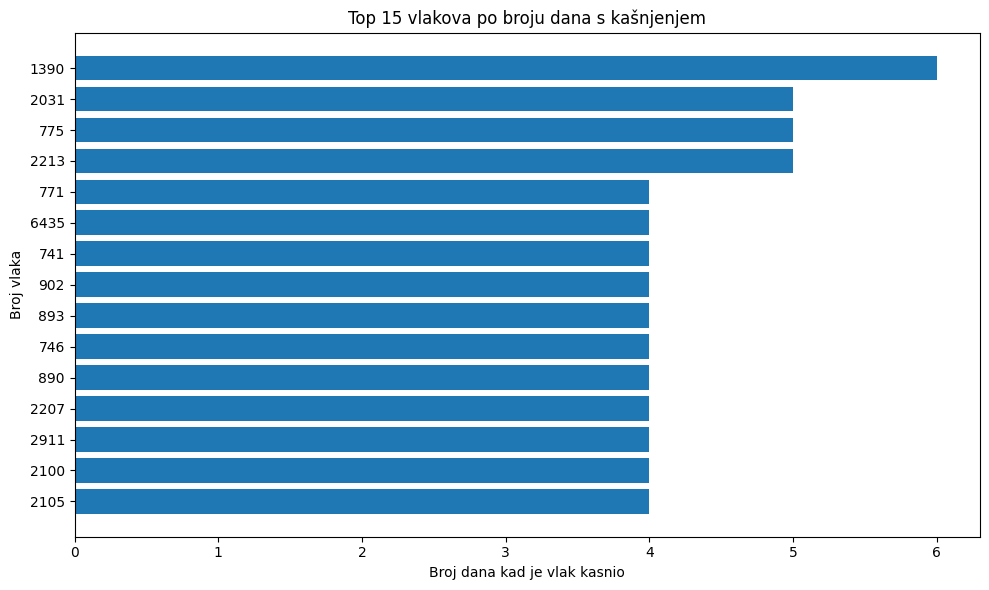

,train_no,route_long_name,first_stop,last_stop,days_late,avg_delay_when_late
89,1390,Ploče - Metković,Ploče,Metković,6,4.00
122,2031,Zagreb Glavni kolodvor - Slavonski Brod,Zagreb Glavni kolodvor,Slavonski Brod,5,4.20
37,775,Zagreb Glavni kolodvor - Bjelovar,Gradec,Bjelovar,5,3.80
152,2213,Zagreb Glavni kolodvor - Koprivnica,Zagreb Glavni kolodvor,Koprivnica,5,10.20
36,771,Zagreb Glavni kolodvor - Koprivnica,Zagreb Glavni kolodvor,Koprivnica,4,7.00
692,6435,Zagreb Glavni kolodvor - Kloštar,Koprivnica,Kloštar,4,10.50
27,741,Zaprešić - Vinkovci,Zagreb Glavni kolodvor,Vinkovci,4,9.00
57,902,Zagreb Glavni kolodvor - Karlovac,Zagreb Glavni kolodvor,Karlovac,4,8.75
54,893,Hromec - Zabok,Krapina,Zabok,4,15.50
32,746,Tovarnik - Zagreb Glavni kolodvor,Vinkovci,Zagreb Glavni kolodvor,4,25.25


In [26]:
top15_freq = (
    data.assign(late=(data["delay_min"] > 0).astype(int))
    .groupby(["train_no","route_long_name","first_stop","last_stop"], as_index=False)
    .agg(days_late=("late","sum"), avg_delay_when_late=("delay_min", lambda s: s[s>0].mean()))
    .sort_values("days_late", ascending=False)
    .head(15)
)

plt.figure(figsize=(10,6))
plt.barh(top15_freq["train_no"].astype(str), top15_freq["days_late"])
plt.title("Top 15 vlakova po broju dana s kašnjenjem")
plt.xlabel("Broj dana kad je vlak kasnio")
plt.ylabel("Broj vlaka")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

top15_freq

U ovom grafu su prikazana odradište koja imaju najveći broj kašnjenja to jest gdje putuju vlakovi koji najviše puta kasne. Na y-osi prikazani su gradovi to jest odredišta pojedinog vlaka, a na x-osi su prikazani broj vlakova koji su sa kašnjenjem stigli na to odredište u navedenom razdoblju. Rezultati imaju smisla jer gradovi koji imaju najviše vlakova koji su došli sa kašnjenjem su Zagreb GLavni kolodvor i Vinkovci koji su najveći kolodvori u Hrvatskoj pa shodno tome imaju i najveći broj vlakova koji u njih pristižu sa kašnjenjem.

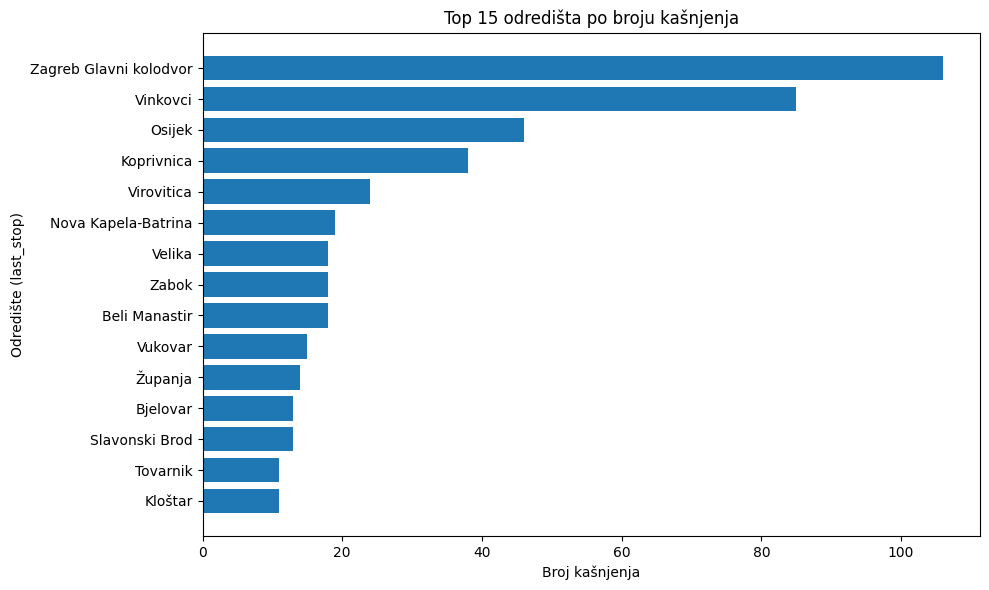

,last_stop,days_late
68,Zagreb Glavni kolodvor,106
63,Vinkovci,85
37,Osijek,46
21,Koprivnica,38
64,Virovitica,24
33,Nova Kapela-Batrina,19
61,Velika,18
67,Zabok,18
1,Beli Manastir,18
66,Vukovar,15


In [38]:
top_dest_freq = (
    data.assign(late=(data["delay_min"] > 0).astype(int))
    .groupby("last_stop", as_index=False)
    .agg(days_late=("late","sum"))
    .sort_values("days_late", ascending=False)
    .head(15)
)

plt.figure(figsize=(10,6))
plt.barh(top_dest_freq["last_stop"], top_dest_freq["days_late"])
plt.title("Top 15 odredišta po broju kašnjenja")
plt.xlabel("Broj kašnjenja")
plt.ylabel("Odredište (last_stop)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

top_dest_freq


Posljednji graf to jest box plot prikazuje kašnjenja u minutama kroz doba dana. Na y-osi su prikazana kašnjenja u minutama. Na x-osi su prikazana doba dana noć(00-6), jutro(6-12), popodne(12-18) i večer (18-00). Box plot prikazuje da se više ekstremnih kašnjenja događa tijeko jutra i popodneva što ima smisla jer je tada puno gušći promet vlakova nego tijekom večeri i noći pa je samim time i logično da će i eventualna kašnjenja biti dulja.

/tmp/ipython-input-434238010.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals, labels=groups, showfliers=True)


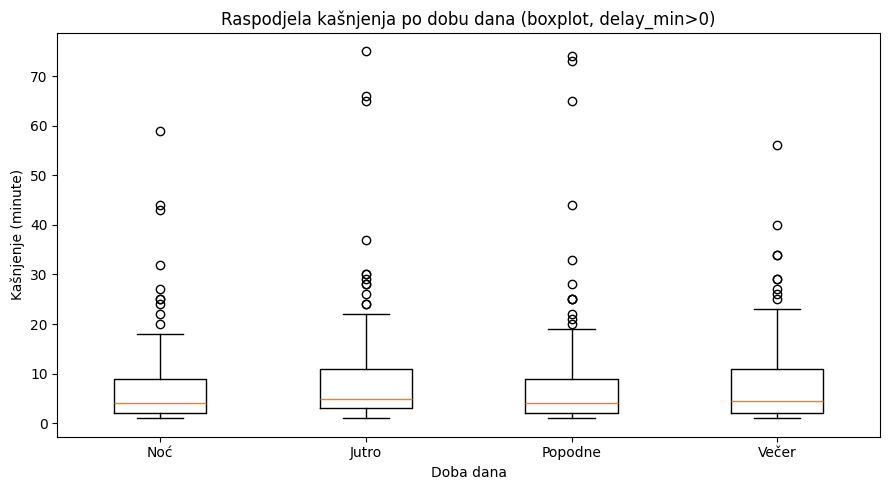

In [37]:
data2 = data.merge(train_base[["train_no","first_dep"]], on="train_no", how="left")

def day_part(minutes):
    if pd.isna(minutes):
        return "Nepoznato"
    m = minutes % (24*60)
    if m < 6*60:
        return "Noć"
    elif m < 12*60:
        return "Jutro"
    elif m < 18*60:
        return "Popodne"
    else:
        return "Večer"

data2["doba_dana"] = data2["first_dep"].apply(day_part)

groups = ["Noć", "Jutro", "Popodne", "Večer"]
vals = [data2[(data2["doba_dana"]==g) & (data2["delay_min"]>0)]["delay_min"].values for g in groups]

plt.figure(figsize=(9,5))
plt.boxplot(vals, labels=groups, showfliers=True)
plt.title("Raspodjela kašnjenja po dobu dana (boxplot, delay_min>0)")
plt.xlabel("Doba dana")
plt.ylabel("Kašnjenje (minute)")
plt.tight_layout()
plt.show()
